# AB Testing with causaltune

In [89]:
import os
import sys
import pandas as pd
import numpy as np
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import gc

root_path = root_path = os.path.realpath('../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import generate_synth_data_with_categories

from flaml import AutoML
import wise_pizza as wp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*Note*: This notebook uses the the package *wise-pizza* which is not listed as a requirement to run causaltune. It is merely used to showcase what is possible as an AB testing workflow.

Install via
`pip install wise-pizza`

## Causaltune for AB Testing 

Causaltune can be used for AB Testing in two ways:
1. Variance Reduction
2. Segmentation analysis

#### 1. Variance Reduction
A standard variance reduction technique is to control for natural variation in the experiment's outcome metric. The simplest way to do so is by running a simple regression with a selection of controls. A potentially more powerful and automated approach is to run causaltune. 

#### 2. Segmentation Analysis

We use the heterogeneous treatment effect estimates from causaltune to feed them into the segmentation analytics tool Wise-Pizza.

#### Data Generating Process

We first create synthetic data from a DGP with perfect randomisation of the treatment as we are replicating an AB test environment

There is substantial variation within the outcome metric per variant:

<Axes: xlabel='Y', ylabel='Density'>

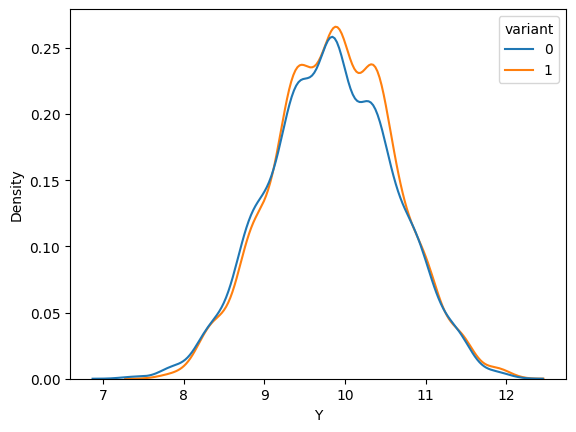

In [93]:
cd = generate_synth_data_with_categories(n_samples=5000, n_x=5)
cd.preprocess_dataset()
sns.kdeplot(data=cd.data, x=cd.outcomes[0], hue=cd.treatment)

### 1. ATE estimation: Running causaltune


In [83]:
# causaltune configuration
num_samples = 20
components_time_budget = 10
train_size = 0.7

target = cd.outcomes[0]

In [ ]:
ct = CausalTune(
    num_samples=num_samples,
    components_time_budget=components_time_budget,
    metric="energy_distance",
    verbose=3,
    components_verbose=3,
    train_size=train_size,
)   
ct.fit(data=cd, outcome=target)

Difference in means estimate (naive ATE):

In [75]:
ct.scorer.naive_ate(cd.data[cd.treatment], cd.data[target])[0]

Causatune ATE estimate:

In [76]:
ct.effect(ct.test_df).mean()

### Explainable variation

As a first performance check of this approach we test how much of the variation in the outcome metric remains unexplained with our outcome model prediction approach. 

For this, we use AutoML to predict outcomes as is done under the hood of causaltune.
The lower the unexplained variation, the more promising it is to use causaltune for AB Testing.

In [77]:
automl = AutoML()
automl.fit(cd.data[cd.data.columns.drop([target])], cd.data[target], task='regression', time_budget=60)

[flaml.automl: 05-21 11:29:30] {2599} INFO - task = regression
[flaml.automl: 05-21 11:29:30] {2601} INFO - Data split method: uniform
[flaml.automl: 05-21 11:29:30] {2604} INFO - Evaluation method: cv
[flaml.automl: 05-21 11:29:30] {2726} INFO - Minimizing error metric: 1-r2
[flaml.automl: 05-21 11:29:30] {2870} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 05-21 11:29:30] {3166} INFO - iteration 0, current learner lgbm
[flaml.automl: 05-21 11:29:30] {3296} INFO - Estimated sufficient time budget=231s. Estimated necessary time budget=2s.
[flaml.automl: 05-21 11:29:30] {3343} INFO -  at 0.0s,	estimator lgbm's best error=0.9024,	best estimator lgbm's best error=0.9024
[flaml.automl: 05-21 11:29:30] {3166} INFO - iteration 1, current learner lgbm
[flaml.automl: 05-21 11:29:30] {3343} INFO -  at 0.1s,	estimator lgbm's best error=0.9024,	best estimator lgbm's best error=0.9024
[flaml.automl: 05-21 11:29:30] {3166} INFO - 

In [78]:
# Fraction of variation unexplained
mse = mean_squared_error(automl.predict(ct.test_df[ct.test_df.columns.drop([target])]), ct.test_df[target])
var_y = cd.data[target].var()
fvu = mse / var_y
print(f'Variation unexplained: {100*fvu:.2f}%')

Variation unexplained: 0.00%


### Bootstrapping with simple component models for inference


In [79]:
# bootstrap configuration

n_samples = 50
n_sample_size = cd.data.shape[0]

components_time_budget = 10
train_size = .7
num_samples= 20

ct_ate = []
scores = []
naive_ate = []

In [ ]:
for _ in range(n_samples):
    cd_bt = generate_synth_data_with_categories(n_samples=5000, n_x=5)
    cd_bt.preprocess_dataset()
    outcome_regressor = RandomForestRegressor()
    
    ct = CausalTune(
        num_samples=num_samples,
        components_time_budget=components_time_budget,
        metric="energy_distance",
        train_size=train_size,
        propensity_model='dummy',
        outcome_model=outcome_regressor
        )        

    ct.fit(data=cd, outcome=target)

    ct_ate.append(ct.effect(ct.test_df).mean())
    scores.append(ct.best_score)
    naive_ate.append(ct.scorer.naive_ate(cd_bt.data[cd_bt.treatment], cd_bt.data[target])[0])
    del ct, cd_bt, outcome_regressor
    gc.collect()

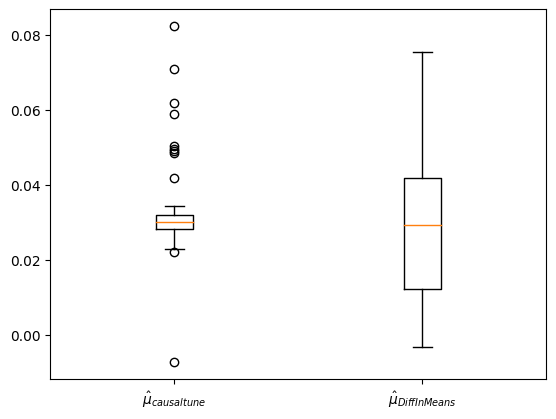

In [81]:
fig, ax = plt.subplots()

ax.boxplot([ct_ate, naive_ate])
ax.set_xticklabels(['$\hat{\mu}_{causaltune}$', '$\hat{\mu}_{DiffInMeans}$'])
plt.show()

### 2. Segmentation with Wise Pizza

The underlying estimators of causaltune provide heterogeneous treatment effect estimates. Apart from simply predicting treatment effects for customers with certain characteristics, one can also perform an automatic segmentation of customers by treatment impact via [wise-pizza](https://github.com/transferwise/wise-pizza/tree/main) as we demonstrate here.

The plot below displays an automatet selection of relevant segments by CATE.

In [87]:
segments = list(set(cd.data.columns) - set([cd.treatment]) - set(cd.outcomes) - set(['random']) - set(['X_continuous']))

ps_counts = (
    cd.data#.loc[cd.data[cd.treatment].isin([0, cd.treatment]), :]
    .groupby(by=segments)[cd.treatment]
    .agg("count")
)

df_effects = pd.concat([ct.test_df[segments], pd.Series(ct.effect(ct.test_df).flatten(), name='CATE')], axis=1)
df_eff_by_seg = df_effects.groupby(by=segments)['CATE'].agg('mean')

df_wp = pd.concat([df_eff_by_seg, ps_counts], axis=1).reset_index()
df_wp['totals'] = df_wp['variant'] * df_wp['CATE']

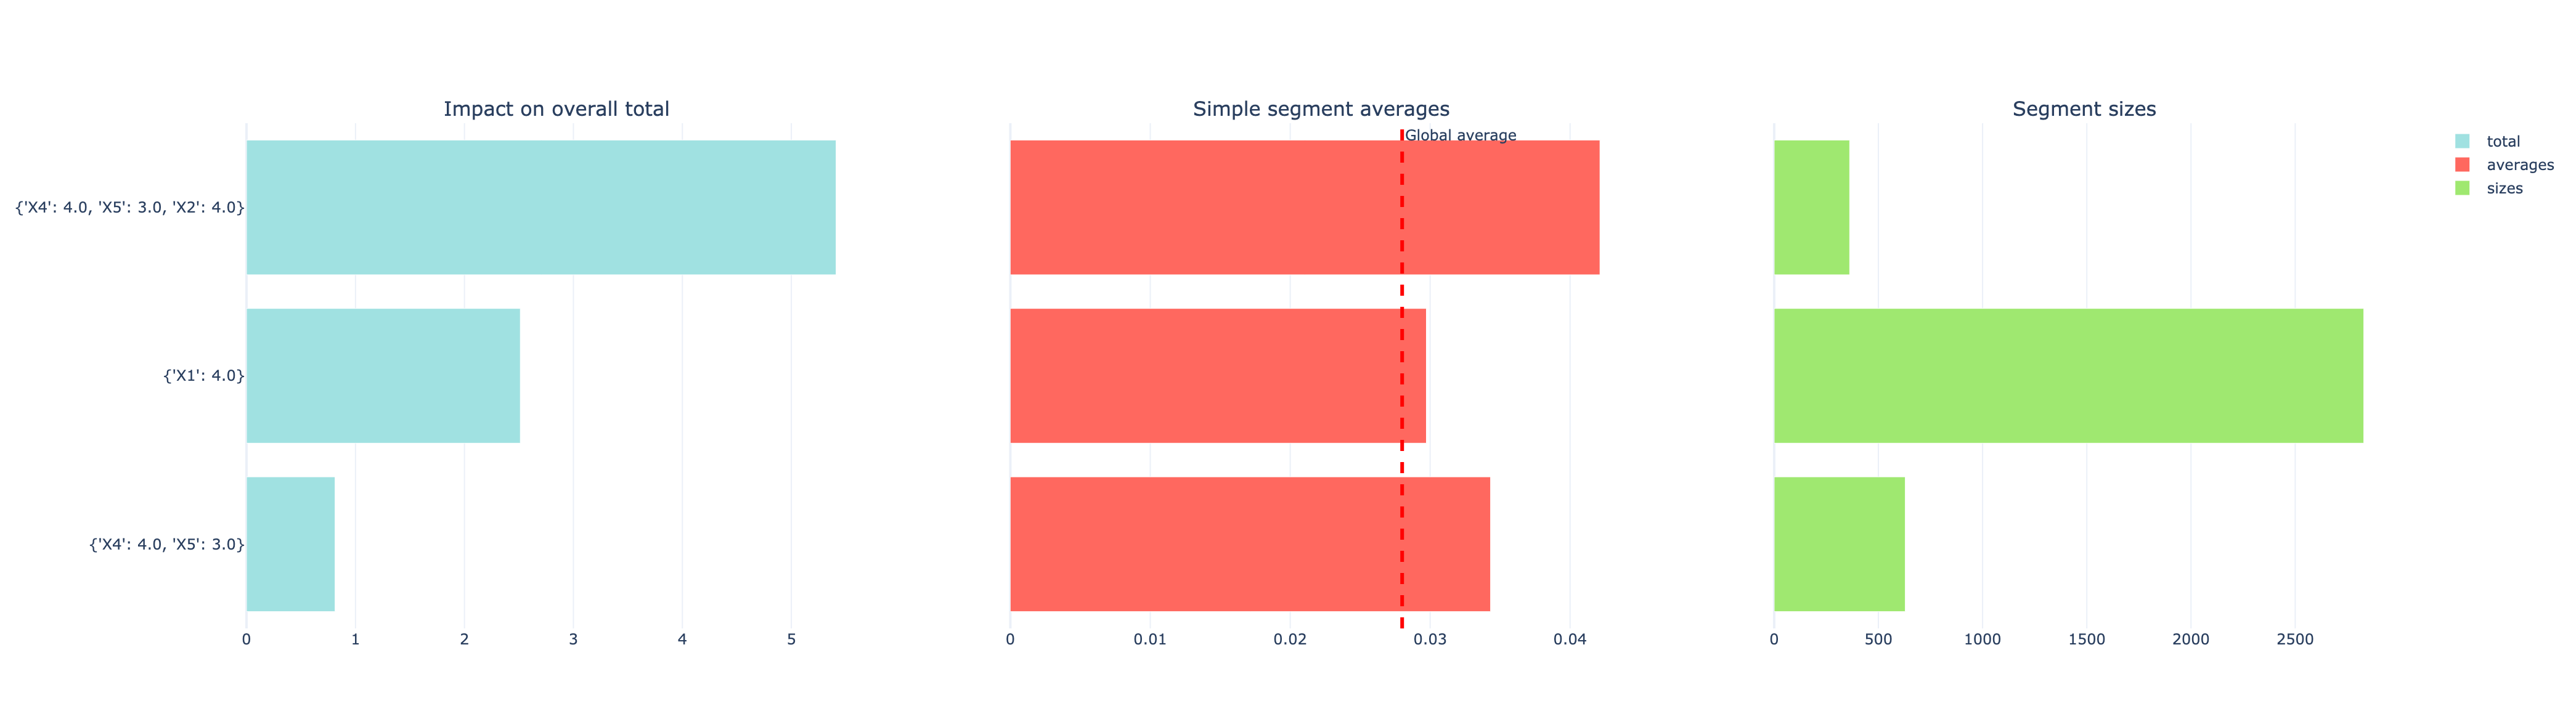

In [88]:
max_depth = 3
min_segments = 3

sf = wp.explain_levels(
    df=df_wp,
    dims=segments,
    total_name='totals',
    size_name=cd.treatment,
    max_depth=max_depth,
    min_segments=min_segments,
)
sf.plot()